# TPCC OU Data Collection

In [83]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import lightgbm as lgb
from datetime import datetime
from pathlib import Path
from scipy import stats

In [84]:
BENCHMARK_NAME = "tpcc"
results_dir = Path.home() / "postgres/cmudb/tscout/results/" / BENCHMARK_NAME
results_dir

PosixPath('/home/glhess/postgres/cmudb/tscout/results/tpcc')

In [85]:
# experiment_dirs = sorted(list(results_dir.glob("*")))

In [86]:
exp_name = "2021-11-16_00-17-38"
exp_dir = results_dir / exp_name
result_filepaths = list(exp_dir.glob("**/*.csv"))
print(exp_dir)

/home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38


#### Load Data

In [124]:
ou_name_to_df = dict()
run_id = 1

for filepath in result_filepaths:
    ou_name = filepath.stem
    
    if run_id != int(filepath.parent.stem): 
        continue
    
    if os.stat(filepath).st_size > 0:
        print(f"Loading filepath: {filepath}")
        ou_name_to_df[ou_name] = pd.read_csv(filepath)

Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecSeqScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecResult.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecModifyTable.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecIndexScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecAgg.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecIndexOnlyScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecLimit.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecSort.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc/2021-11-16_00-17-38/1/ExecValuesScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/result

In [125]:
for (ou_name, ou_df) in ou_name_to_df.items():
    print(f"OU Name: {ou_name}, ou_df shape: {ou_df.shape}")

OU Name: ExecSeqScan, ou_df shape: (21537, 36)
OU Name: ExecResult, ou_df shape: (24245, 36)
OU Name: ExecModifyTable, ou_df shape: (166776, 51)
OU Name: ExecIndexScan, ou_df shape: (281701, 43)
OU Name: ExecAgg, ou_df shape: (6523, 64)
OU Name: ExecIndexOnlyScan, ou_df shape: (7278, 43)
OU Name: ExecLimit, ou_df shape: (7692, 42)
OU Name: ExecSort, ou_df shape: (136, 42)
OU Name: ExecValuesScan, ou_df shape: (13552, 37)
OU Name: ExecLockRows, ou_df shape: (227938, 36)
OU Name: ExecNestLoop, ou_df shape: (714, 40)


# Pre-processing

#### Get IndexScan OU Data

In [159]:
target_ou = 'ExecNestLoop'
df = ou_name_to_df[target_ou]

### Remove Start/End Time (since elapsed_us == end_time - start_time)

In [160]:
cols_to_remove = ['start_time', 'end_time', 'cpu_id', 'query_id']
df = df.drop(cols_to_remove, axis=1)

#### Remove constant columns

In [161]:
cols_to_remove = []
for col in df.columns:
    if df[col].nunique() == 1: 
            cols_to_remove.append(col)

df = df.drop(cols_to_remove, axis=1)
print(f"Dropped zero-variance columns: {cols_to_remove}")
print(f"Num Remaining: {len(df.columns)}, Num Removed {len(cols_to_remove)}")

Dropped zero-variance columns: ['NestLoopState_js_ps_type', 'NestLoopState_js_ps_async_capable', 'NestLoopState_js_ps_scanopsfixed', 'NestLoopState_js_ps_outeropsfixed', 'NestLoopState_js_ps_inneropsfixed', 'NestLoopState_js_ps_resultopsfixed', 'NestLoopState_js_ps_scanopsset', 'NestLoopState_js_ps_outeropsset', 'NestLoopState_js_ps_inneropsset', 'NestLoopState_js_ps_resultopsset', 'NestLoopState_js_jointype', 'NestLoopState_js_single_match', 'NestLoopState_nl_NeedNewOuter', 'NestLoop_join_plan_type', 'NestLoop_join_plan_plan_width', 'NestLoop_join_plan_parallel_aware', 'NestLoop_join_plan_parallel_safe', 'NestLoop_join_plan_async_capable', 'NestLoop_join_plan_plan_node_id', 'NestLoop_join_jointype', 'NestLoop_join_inner_unique', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'disk_bytes_written', 'memory_bytes']
Num Remaining: 10, Num Removed 26


### Summarize Features

In [162]:
all_target_cols = ['cpu_cycles', 'instructions', 'cache_references', 'cache_misses', 'ref_cpu_cycles', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'disk_bytes_written', 'memory_bytes', 'elapsed_us']
feat_cols = [col for col in df.columns if col not in all_target_cols]
features = df[feat_cols]
features.describe()

,NestLoopState_nl_MatchedOuter,NestLoop_join_plan_startup_cost,NestLoop_join_plan_total_cost,NestLoop_join_plan_plan_rows
count,714.000000,714.000000,714.000000,714.000000
mean,0.063025,0.759821,56.882945,1.165266
std,0.243179,0.422148,195.703214,1.110007
min,0.000000,0.707500,16.760481,1.000000
25%,0.000000,0.715000,16.764362,1.000000
50%,0.000000,0.715000,16.766278,1.000000
75%,0.000000,0.715000,16.779319,1.000000
max,1.000000,4.722750,1231.630263,13.000000


### Summarize Targets

In [163]:
target_cols = [col for col in df.columns if col in all_target_cols]
targets = df[target_cols]
targets.describe()

,cpu_cycles,instructions,cache_references,cache_misses,ref_cpu_cycles,elapsed_us
count,7.140000e+02,7.140000e+02,7.140000e+02,714.000000,7.140000e+02,714.000000
mean,1.109467e+07,1.102323e+07,2.740289e+05,37399.976190,6.268474e+06,2392.871148
std,6.806170e+06,6.141288e+06,1.751357e+05,25103.583698,4.804575e+06,414.736392
min,3.351890e+05,4.326880e+05,1.706500e+04,3104.000000,4.384860e+05,304.000000
25%,2.939892e+06,3.559548e+06,1.681740e+05,8505.250000,1.543787e+06,2170.500000
50%,1.381031e+07,1.339234e+07,2.180690e+05,43619.000000,5.561778e+06,2366.500000
75%,1.660071e+07,1.655138e+07,3.535610e+05,58753.750000,1.076361e+07,2583.250000
max,2.758594e+07,2.155908e+07,1.099797e+06,92654.000000,1.849652e+07,3801.000000


## Show Features

In [164]:
features.head(5)

,NestLoopState_nl_MatchedOuter,NestLoop_join_plan_startup_cost,NestLoop_join_plan_total_cost,NestLoop_join_plan_plan_rows
0,0,0.7075,17.111556,1.0
1,0,0.7075,17.111556,1.0
2,0,0.7075,17.111556,1.0
3,0,0.7075,17.111556,1.0
4,0,0.7075,17.111556,1.0


## Show targets

In [165]:
targets.head(5)

,cpu_cycles,instructions,cache_references,cache_misses,ref_cpu_cycles,elapsed_us
0,11818227,11669275,118022,73418,1340848,2236
1,6933305,3581719,295744,17496,7889578,3005
2,11017706,10182284,176796,28280,1038214,2138
3,13129612,12559191,133966,7502,1210142,2456
4,2921416,2566997,128557,57311,8103029,2450


In [166]:
def plot_histograms(df): 
    for col_name in df.columns: 
        res = stats.relfreq(df[col_name], numbins=10)
        x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                         res.frequency.size)
        fig = plt.figure(figsize=(6, 2))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x, res.frequency, width=res.binsize)
        ax.set_title(col_name)
        ax.set_xlim([x.min(), x.max()])

#### Visualizations

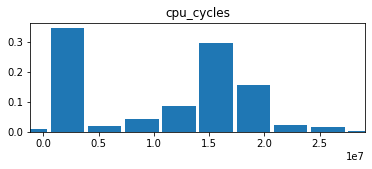

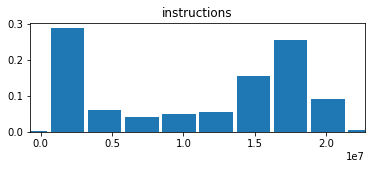

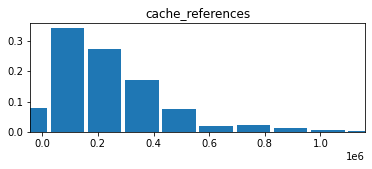

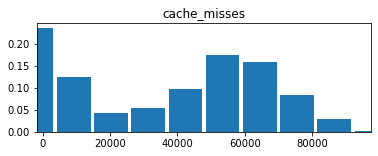

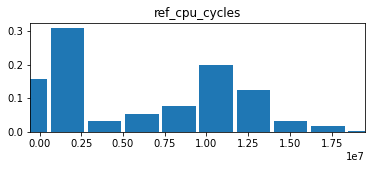

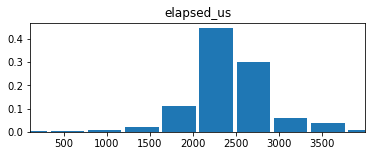

In [167]:
plot_histograms(targets)

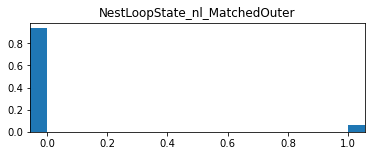

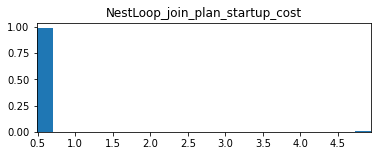

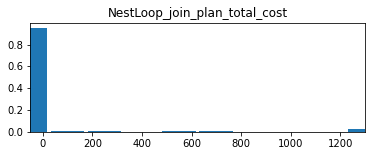

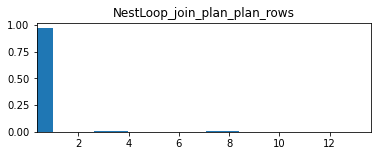

In [168]:
plot_histograms(features)

#### Correlation Heatmap

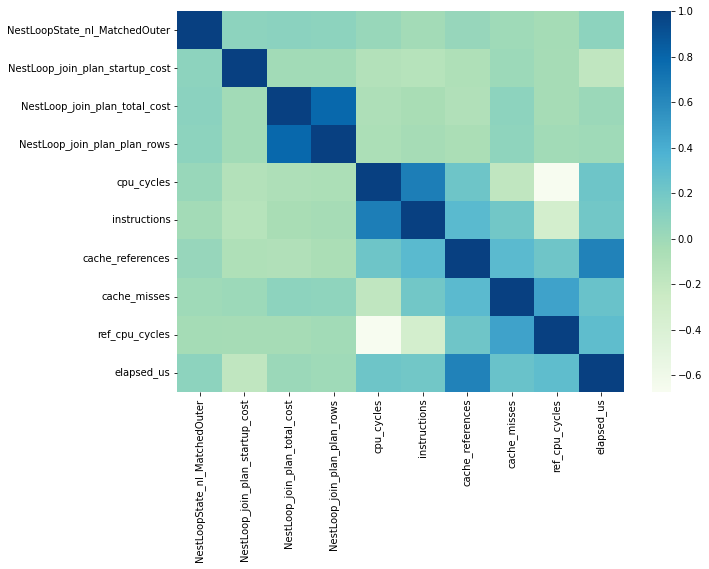

In [169]:
df_corr = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(df_corr, cmap='GnBu')
plt.show()

# Feature Analysis - PCA

In [156]:
def pca_summary(df):
    pca = PCA(n_components=None)
    pca.fit(df)
    print(f"Input Dimensionality: {len(df.columns)}")
    for component_idx, explained_var_pct in enumerate(pca.explained_variance_ratio_):
        print(f"Component {component_idx} explains {round(explained_var_pct*100, 2)}% of variance")

In [157]:
pca_summary(df)

Input Dimensionality: 10
Component 0 explains 73.93% of variance
Component 1 explains 17.06% of variance
Component 2 explains 8.9% of variance
Component 3 explains 0.12% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance
Component 6 explains 0.0% of variance
Component 7 explains 0.0% of variance
Component 8 explains 0.0% of variance
Component 9 explains 0.0% of variance


In [158]:
features.columns

Index(['Scan_plan_total_cost', 'Scan_plan_plan_width',
       'Scan_plan_parallel_safe', 'Scan_plan_plan_node_id'],
      dtype='object')

In [103]:
pca_summary(features)

Input Dimensionality: 11
Component 0 explains 99.94% of variance
Component 1 explains 0.05% of variance
Component 2 explains 0.0% of variance
Component 3 explains 0.0% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance
Component 6 explains 0.0% of variance
Component 7 explains 0.0% of variance
Component 8 explains 0.0% of variance
Component 9 explains 0.0% of variance
Component 10 explains 0.0% of variance
